In [1]:
import rasterio as rio
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime

In [2]:
def calc_ndvi(image_file , aoi_bbox=None):
    with rio.open(image_file) as src:
        window = None
        if aoi_bbox is not None:
            window = src.window(*aoi_bbox)
        band_red = src.read(3, window=window)

    with rio.open(image_file) as src:
        window = None
        if aoi_bbox is not None:
            window = src.window(*aoi_bbox)

        band_nir = src.read(4, window=window)
        np.seterr(divide='ignore', invalid='ignore')

    ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)
    return ndvi

## NDVI for one example

In [3]:
root_dir = 'data'
image_file = '20200814_105841_1053_3B_AnalyticMS.tif'

path = Path(root_dir).rglob(image_file)
ndvi = calc_ndvi(next(path))
print(f'{np.nanmin(ndvi)}, {np.nanmax(ndvi)}')

-0.7932651321398124, 0.7209793161671592


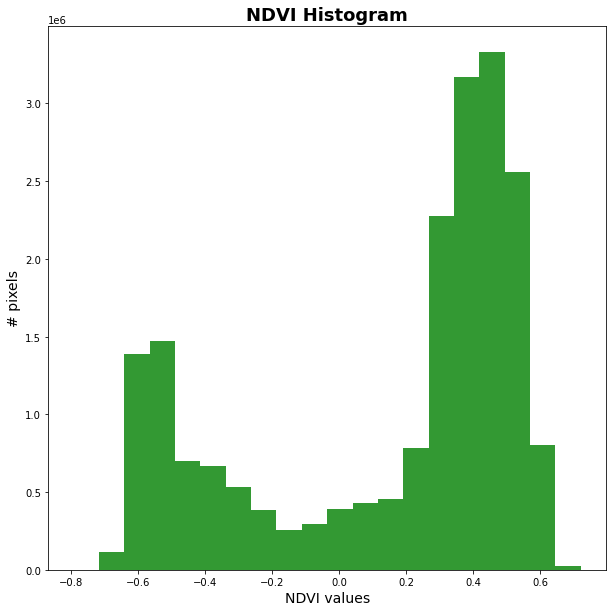

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)
plt.show()

## Aggregate NDVI from all examples

Change the root_dir to the root location of the tiff files!!

In [5]:
results = []
root_dir = 'data'

## this is a hack, open first tif to get the crs, raster and vector data have to use same crs.
target_crs = rio.open(next(Path(root_dir).rglob('*MS.tif'))).crs

aoi = r'test_geometry.geojson'
aoi_df = gpd.read_file(aoi)
aoi_df = aoi_df.to_crs(crs=target_crs)
aoi_bbox = aoi_df.total_bounds


for path in Path(root_dir).rglob('*MS.tif'):
    print(f'processing: {path.name}')
    ndvi = calc_ndvi(path, aoi_bbox=aoi_bbox)
    dt = datetime.datetime.strptime(path.name[0:15], '%Y%m%d_%H%M%S')
    results.append((dt, np.nanmean(ndvi), np.nanmin(ndvi), np.nanmax(ndvi)))
#[print(r) for r in results];

processing: 20200814_105841_1053_3B_AnalyticMS.tif
processing: 20200814_105836_1053_3B_AnalyticMS.tif
processing: 20200814_105837_1053_3B_AnalyticMS.tif
processing: 20200814_105840_1053_3B_AnalyticMS.tif
processing: 20200814_105838_1053_3B_AnalyticMS.tif
processing: 20200814_105839_1053_3B_AnalyticMS.tif


## Write dataframe

Write results to a dataframe using acquired datatime as index

In [6]:
df = pd.DataFrame(results, columns=['acquired', 'mean', 'min', 'max'])
df = df.set_index('acquired')
df.head()

,mean,min,max
acquired,,,
2020-08-14 10:58:41,0.350550,-0.558735,0.711348
2020-08-14 10:58:36,-0.065776,-0.722446,0.699334
2020-08-14 10:58:37,0.169951,-0.724834,0.714040
2020-08-14 10:58:40,0.294269,-0.642276,0.721687
2020-08-14 10:58:38,0.247755,-0.704122,0.720332


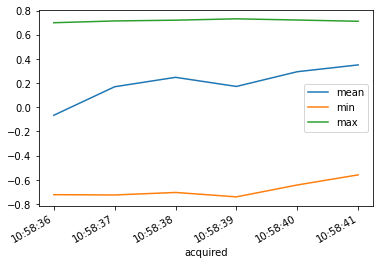

In [7]:
fig, ax = plt.subplots()
df.plot(ax=ax)
plt.show()

In [8]:
df.to_csv('first_results.csv')

In [9]:
results_df = pd.read_csv('first_results.csv', index_col='acquired', parse_dates=True)
results_df.head()

,mean,min,max
acquired,,,
2020-08-14 10:58:41,0.350550,-0.558735,0.711348
2020-08-14 10:58:36,-0.065776,-0.722446,0.699334
2020-08-14 10:58:37,0.169951,-0.724834,0.714040
2020-08-14 10:58:40,0.294269,-0.642276,0.721687
2020-08-14 10:58:38,0.247755,-0.704122,0.720332
